In [144]:
import re
import math
import time
import codecs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from functools import wraps
from datetime import datetime

from scipy.spatial import Voronoi
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KernelDensity

import keras.backend as K
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda, BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold

%matplotlib inline

In [145]:
# TRAIN_DATA_PATH = Path('../input/nfl-big-data-bowl-2020/train.csv')
TRAIN_DATA_PATH = Path('../src/vector_build/train.csv')
SEED = 0

In [146]:
train = pd.read_csv(TRAIN_DATA_PATH, dtype={'WindSpeed': 'object'})
train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [147]:
replacements = [
    ('LSU', 'Louisiana State'),
    ('Southern California', 'USC'),
    ('Miami (Fla.)', 'Miami'),
    ('Miami, O.', 'Miami OH'),
    ('Miami (Ohio)', 'Miami OH'),
    ('Texas-El Paso', 'Texas')
]

In [148]:
college_to_conf = {
    'Air Force' : 'Mountain West Conference',
    'Akron' : 'Mid-American Conference',
    'Alabama' : 'Southeastern Conference',
    'Alabama-Birmingham' : 'Conference USA',
    'Appalachian State' : 'Sun Belt Conference',
    'Arizona' : 'Pacific 12 Conference',
    'Arizona State' : 'Pacific 12 Conference',
    'Arkansas' : 'Southeastern Conference',
    'Arkansas State' : 'Sun Belt Conference',
    'Army' : 'Independents',
    'Auburn' : 'Southeastern Conference',
    'Ball State' : 'Mid-American Conference',
    'Baylor' : 'Big 12 Conference',
    'Boise State' : 'Mountain West Conference',
    'Boston College' : 'Atlantic Coast Conference',
    'Bowling Green' : 'Mid-American Conference',
    'Brigham Young' : 'Independents',
    'Buffalo' : 'Mid-American Conference',
    'California' : 'Pacific 12 Conference',
    'Central Florida' : 'American Athletic Conference',
    'Central Michigan' : 'Mid-American Conference',
    'Cincinnati' : 'American Athletic Conference',
    'Clemson' : 'Atlantic Coast Conference',
    'Coastal Carolina' : 'Sun Belt Conference',
    'Colorado' : 'Pacific 12 Conference',
    'Colorado State' : 'Mountain West Conference',
    'Connecticut' : 'American Athletic Conference',
    'Duke' : 'Atlantic Coast Conference',
    'East Carolina' : 'American Athletic Conference',
    'Eastern Michigan' : 'Mid-American Conference',
    'Florida' : 'Southeastern Conference',
    'Florida Atlantic' : 'Conference USA',
    'Florida International' : 'Conference USA',
    'Florida State' : 'Atlantic Coast Conference',
    'Fresno State' : 'Mountain West Conference',
    'Georgia' : 'Southeastern Conference',
    'Georgia Southern' : 'Sun Belt Conference',
    'Georgia State' : 'Sun Belt Conference',
    'Georgia Tech' : 'Atlantic Coast Conference',
    'Hawai`i' : 'Mountain West Conference',
    'Houston' : 'American Athletic Conference',
    'Illinois' : 'Big 10 Conference',
    'Indiana' : 'Big 10 Conference',
    'Iowa' : 'Big 10 Conference',
    'Iowa State' : 'Big 12 Conference',
    'Kansas' : 'Big 12 Conference',
    'Kansas State' : 'Big 12 Conference',
    'Kent State' : 'Mid-American Conference',
    'Kentucky' : 'Southeastern Conference',
    'Liberty' : 'Independents',
    'Louisiana Tech' : 'Conference USA',
    'Louisiana-Lafayette' : 'Sun Belt Conference',
    'Louisiana-Monroe' : 'Sun Belt Conference',
    'Louisville' : 'Atlantic Coast Conference',
    'Louisiana State' : 'Southeastern Conference',
    'Marshall' : 'Conference USA',
    'Maryland' : 'Big 10 Conference',
    'Massachusetts' : 'Independents',
    'Memphis' : 'American Athletic Conference',
    'Miami' : 'Atlantic Coast Conference',
    'Miami OH' : 'Mid-American Conference',
    'Michigan' : 'Big 10 Conference',
    'Michigan State' : 'Big 10 Conference',
    'Middle Tennessee State' : 'Conference USA',
    'Minnesota' : 'Big 10 Conference',
    'Mississippi' : 'Southeastern Conference',
    'Mississippi State' : 'Southeastern Conference',
    'Missouri' : 'Southeastern Conference',
    'Navy' : 'American Athletic Conference',
    'Nebraska' : 'Big 10 Conference',
    'Nevada' : 'Mountain West Conference',
    'New Mexico' : 'Mountain West Conference',
    'New Mexico State' : 'Independents',
    'North Carolina' : 'Atlantic Coast Conference',
    'North Carolina State' : 'Atlantic Coast Conference',
    'North Texas' : 'Conference USA',
    'Northern Illinois' : 'Mid-American Conference',
    'Northwestern' : 'Big 10 Conference',
    'Notre Dame' : 'Independents',
    'Ohio State' : 'Big 10 Conference',
    'Ohio' : 'Mid-American Conference',
    'Oklahoma' : 'Big 12 Conference',
    'Oklahoma State' : 'Big 12 Conference',
    'Old Dominion' : 'Conference USA',
    'Oregon' : 'Pacific 12 Conference',
    'Oregon State' : 'Pacific 12 Conference',
    'Penn State' : 'Big 10 Conference',
    'Pittsburgh' : 'Atlantic Coast Conference',
    'Purdue' : 'Big 10 Conference',
    'Rice' : 'Conference USA',
    'Rutgers' : 'Big 10 Conference',
    'San Diego State' : 'Mountain West Conference',
    'San Jose State' : 'Mountain West Conference',
    'SMU' : 'American Athletic Conference',
    'South Alabama' : 'Sun Belt Conference',
    'South Carolina' : 'Southeastern Conference',
    'South Florida' : 'American Athletic Conference',
    'USC' : 'Pacific 12 Conference',
    'Southern Miss' : 'Conference USA',
    'Stanford' : 'Pacific 12 Conference',
    'Syracuse' : 'Atlantic Coast Conference',
    'Texas Christian' : 'Big 12 Conference',
    'Temple' : 'American Athletic Conference',
    'Tennessee' : 'Southeastern Conference',
    'Texas' : 'Big 12 Conference',
    'Texas A&M' : 'Southeastern Conference',
    'Texas State' : 'Sun Belt Conference',
    'Texas Tech' : 'Big 12 Conference',
    'Texas-San Antonio' : 'Conference USA',
    'Toledo' : 'Mid-American Conference',
    'Troy' : 'Sun Belt Conference',
    'Tulane' : 'American Athletic Conference',
    'Tulsa' : 'American Athletic Conference',
    'UCLA' : 'Pacific 12 Conference',
    'UNC-Charlotte' : 'Conference USA',
    'UNLV' : 'Mountain West Conference',
    'Utah' : 'Pacific 12 Conference',
    'Utah State' : 'Mountain West Conference',
    'UTEP' : 'Conference USA',
    'Vanderbilt' : 'Southeastern Conference',
    'Virginia' : 'Atlantic Coast Conference',
    'Virginia Tech' : 'Atlantic Coast Conference',
    'Wake Forest' : 'Atlantic Coast Conference',
    'Washington' : 'Pacific 12 Conference',
    'Washington State' : 'Pacific 12 Conference',
    'West Virginia' : 'Big 12 Conference',
    'Western Kentucky' : 'Conference USA',
    'Western Michigan' : 'Mid-American Conference',
    'Wisconsin' : 'Big 10 Conference',
    'Wyoming' : 'Mountain West Conference'
}

In [149]:
position_groups = {
    'CB' : 'DB',
    'FS' : 'DB',
    'SAF' : 'DB',
    'S' : 'DB',
    'SS' : 'DB',
    'DB' : 'DB',
    'OLB' : 'LB',
    'ILB' : 'LB',
    'MLB' : 'LB',
    'LB' : 'LB',
    'DE' : 'DL',
    'DT' : 'DL',
    'NT' : 'DL',
    'DL' : 'DL',
    'G' : 'OL',
    'OG' : 'OL',
    'T' : 'OL',
    'OT' : 'OL',
    'C' : 'OL',
    'RB' : 'RB',
    'FB' : 'RB',
    'HB' : 'RB',
    'WR' : 'SK',
    'QB' : 'SK',
    'TE' : 'SK'
}
posession_positions = {
    'DB': 0,
    'LB': 0,
    'DL': 0,
    'OL': 1,
    'RB': 1,
    'SK': 1
}

In [150]:
COLS_TO_DROP = [
    'Position', 'IsRusher'
]
CATEGORICAL_VARS = [
    'DisplayName', 'PlayerCollegeName', 'GameWeather', 'Location',
    'OffensePersonnel', 'Stadium', 'WindDirection', 'DefensePersonnel',
    'HomeTeamAbbr', 'VisitorTeamAbbr', 'FieldPosition', 'PossessionTeam',
    'StadiumType', 'Position', 'Turf', 'PlayerHeight', 'OffenseFormation',
    'JerseyNumber', 'NflId'
]
TRANSFORMED_CATEGORICALS = [
    'OffensePersonnel', 'DefensePersonnel', 'WindSpeed', 'PlayerHeight',
    'NflId', 'Turf', 'FieldPosition', 'PlayerCollegeName', 'JerseyNumber',
    'PossessionTeam'
]
VARS_TO_ONE_HOT = [var for var in CATEGORICAL_VARS
                   if var not in TRANSFORMED_CATEGORICALS
                   and var not in COLS_TO_DROP]
MAX_CARDINALITY = 24

In [151]:
cardinalities = train[VARS_TO_ONE_HOT].nunique().sort_values(ascending=False)
cardinalities

DisplayName         2230
GameWeather           61
Location              60
Stadium               55
WindDirection         53
VisitorTeamAbbr       32
HomeTeamAbbr          32
StadiumType           29
OffenseFormation       8
dtype: int64

In [152]:
def shoelace(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [153]:
def func_timer(fn):
    @wraps(fn)
    def timer(*args, **kwargs):
        print('\n' + fn.__name__.upper())
        start_time = datetime.now()
        res = fn(*args, **kwargs)
        end_time = datetime.now()
        time_taken = end_time - start_time
        time_taken = time_taken.total_seconds() / 60
        print('{} time taken: {:.2f} mins'.format(fn.__name__, time_taken))
        return res
    return timer

def transformation_check(fn):
    @wraps(fn)
    def checker(*args, **kwargs):
        print(' -- {} -- '.format(fn.__name__))
        res = fn(*args, **kwargs)
        end_shape = res.shape
        null_prc = 100 * (res.isnull().sum() / len(res)).mean()
        print('\tshape = {}'.format(end_shape))
        print('\tnull % = {:.2f}'.format(null_prc))
        return res
    return checker

In [154]:
class Preprocessor(TransformerMixin):
    def __init__(self, one_hot_vars, max_cardinality, cols_to_drop=[]):
        super().__init__()
        self.target = 'Yards'
        self.one_hot_vars = one_hot_vars
        self.max_cardinality = max_cardinality
        self.cols_to_drop = cols_to_drop
        self.player_cols = []
        self.one_hot_encoder = OneHotEncoder(
            sparse=False, 
            dtype=np.int, 
            handle_unknown='ignore'
        )
        self.college_encoding = {}
        self.jersey_encoding = {}

    @func_timer
    def initial_cleaning(self, X):
        """ Transformative steps that don't need any 'fitted'
        objects. Also any thing that needs to be done before anything
        is fit """
        X = self._correct_team_abbreviations(X)
        X = self._encode_player_height(X)
        X = self._process_time_variables(X)
        X = self._fix_wind_variables(X)
        X = self._fix_stadium_type_and_turf(X)
        X = self._map_college_and_pos(X)
        X = self._encode_personnel(X)
        X = self._normalise_positional_data(X)
        X = self._calc_voronoi(X)
        X = self._misc_engineering(X)
        X.drop(columns=self.cols_to_drop, inplace=True)
        return X

    @func_timer
    def fit(self, X, y=None):
        # Get player related columns
        self._get_player_cols(X)

        # Fit one hot encoder
        cardinalities = X[self.one_hot_vars].nunique().to_dict()
        one_hot_vars = [var for var in self.one_hot_vars
                        if cardinalities[var] <= self.max_cardinality]
        self.one_hot_encoder.fit(X[one_hot_vars].fillna('unknown'))
        self.oh_cols_to_drop = [var for var in self.one_hot_vars
                                if var not in one_hot_vars]
        self.one_hot_vars = one_hot_vars
        
        # Fit college name and jersey number 'encoder's
        self.college_encoding = \
            X.groupby('PlayerCollegeName')['PlayId'].count().to_dict()
        self.jersey_encoding = \
            X.groupby('JerseyNumber')['PlayId'].count().to_dict()
        
        return self

    @func_timer
    def transform(self, X):
        X['PlayerCollegeName'] = X['PlayerCollegeName'].map(self.college_encoding)
        X['PlayerCollegeNameRusher'] = \
            X['PlayerCollegeNameRusher'].map(self.college_encoding)
        X['JerseyNumber'] = X['JerseyNumber'].map(self.jersey_encoding)
        X = self._apply_one_hot_encoder(X)
        X = self._flatten_player_vars(X)
        return X

    @transformation_check
    def _correct_team_abbreviations(self, X):
        map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
        for abb in X['PossessionTeam'].unique():
            map_abbr[abb] = abb

        X['PossessionTeam'] = X['PossessionTeam'].map(map_abbr)
        X['HomeTeamAbbr'] = X['HomeTeamAbbr'].map(map_abbr)
        X['VisitorTeamAbbr'] = X['VisitorTeamAbbr'].map(map_abbr)
        return X

    @transformation_check
    def _encode_player_height(self, X):
        def string_to_inches(x):
            feet, inch = x.split('-')
            return int(inch) + 12 * int(feet)

        X['PlayerHeight'] = X['PlayerHeight'].apply(string_to_inches)
        return X

    @transformation_check
    def _process_time_variables(self, X):
        for col in ['TimeHandoff', 'TimeSnap', 'PlayerBirthDate']:
            X[col] = pd.to_datetime(X[col], utc=True, infer_datetime_format=True)
        X['TimeUntilHandoff'] = X['TimeSnap'] - X['TimeHandoff']
        X['TimeUntilHandoff'] = X['TimeUntilHandoff'].dt.total_seconds()

        X['PlayerAge'] = X['TimeSnap'] - X['PlayerBirthDate']
        X['PlayerAge'] = X['PlayerAge'].dt.total_seconds() / 31556952

        X['GameClock'] = 360 * X['GameClock'].str[:2].astype(int) \
                         + 60 * X['GameClock'].str[3:5].astype(int) \
                         + X['GameClock'].str[6:8].astype(int)

        X.drop(columns=['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], inplace=True)
        return X

    @transformation_check
    def _fix_wind_variables(self, X):
        def average_ranges(x):
            x = str(x)
            if '-' in x:
                low, high = x.split('-')
                return str((int(high) + int(low)) / 2)
            elif ' gusts up to ' in x:
                low, high = x.split(' gusts up to ')
                return str((int(high) + int(low)) / 2)
            else:
                return x

        def coerce_to_int(x):
            try:
                x = int(x)
            except:
                x = np.nan
            return x

        X['WindSpeed'] = X['WindSpeed'].str.lower().str.replace('mph', '')
        X['WindSpeed'] = X['WindSpeed'].str.strip()
        X['WindSpeed'] = X['WindSpeed'].apply(average_ranges)
        X['WindSpeed'] = X['WindSpeed'].apply(coerce_to_int)

        acceptable_directions = [
            'NE', 'SW', 'S', 'NW', 'WSW', 'SE', 'W', 'N', 'NNE', 'WNW', 'SSW',
            'NNW', 'SSE', 'E', 'ENE', 'ESE'
        ]
        X['WindDirection'] = X['WindDirection'].str.upper()
        X['WindDirection'] = X['WindDirection'].str.replace('FROM ', '').str.replace('-', '')
        X.loc[~X['WindDirection'].isin(acceptable_directions), 'WindDirection'] = np.nan
        return X
    
    @transformation_check
    def _fix_stadium_type_and_turf(self, X):
        stadium_type_map = {
            'Outdoor': 'Outdoor',
            'Outdoors': 'Outdoor',
            'Indoors': 'Indoor',
            'Dome': 'Indoor',
            'Indoor': 'Indoor',
            'Retractable Roof': 'Retr Open',
            'Open': 'Retr Open',
            'Retr. Roof-Closed': 'Retr Closed',
            'Retr. Roof - Closed': 'Retr Closed',
            'Domed, closed': 'Retr Closed',
            'Domed, open': 'Retr Open',
            'Closed Dome': 'Retr Closed',
            'Dome, closed': 'Retr Closed',
            'Domed': 'Indoor',
            'Oudoor': 'Outdoor',
            'Indoor, Roof Closed': 'Retr Closed',
            'Retr. Roof Closed': 'Retr Closed',
            'Retr. Roof-Open': 'Retr Open',
            'Bowl': 'Outdoor',
            'Outddors': 'Outdoor',
            'Heinz Field': 'Outdoor',
            'Outdoor Retr Roof-Open': 'Retr Open',
            'Retr. Roof - Open': 'Retr Open',
            'Indoor, Open Roof': 'Retr Open',
            'Ourdoor': 'Outdoor',
            'Outdor': 'Outdoor',
            'Outside': 'Outdoor',
            'Cloudy': 'Outdoor',
            'Domed, Open': 'Retr Open'
        }
        turf_map = {
            'Grass': 1,
            'Natural Grass': 1,
            'Field Turf': 1,
            'Artificial': 0,
            'FieldTurf': 1,
            'UBU Speed Series-S5-M': 0,
            'A-Turf Titan': 1,
            'UBU Sports Speed S5-M': 0,
            'FieldTurf360': 1,
            'DD GrassMaster': 0,
            'Twenty-Four/Seven Turf': 1,
            'SISGrass': 0, 
            'FieldTurf 360': 1,
            'Natural grass': 1,
            'Artifical': 0,
            'Natural': 1,
            'Field turf': 0,
            'Naturall Grass': 1,
            'grass': 1,
            'natural grass': 1 
        }
        X['StadiumType'] = X['StadiumType'].map(stadium_type_map)
        X['Turf'] = X['Turf'].map(turf_map).fillna(1).astype(int)
        
        def get_city(x):
            x = x.replace('e.', 'east').replace('.', ',')
            return x.split(',')[0].strip().lower()
        X['Location'] = X['Location'].apply(get_city)
        
        return X
    
    @transformation_check
    def _map_college_and_pos(self, X):
        for replacement in replacements:
            X['PlayerCollegeName'] = X['PlayerCollegeName']\
                .replace(replacement[0], replacement[1])
        X['CollegeConference'] = X['PlayerCollegeName'].map(college_to_conf)
        X['CollegeConference'].fillna('BinJuice', inplace=True)
        if 'CollegeConference' not in self.one_hot_vars:
            self.one_hot_vars += ['CollegeConference']
        
        X['PositionGroup'] = X['Position'].map(position_groups)
        X['InPossesion'] = X['PositionGroup'].map(posession_positions)
        return X

    @transformation_check
    def _encode_personnel(self, X):

        def count_positions(x, offensive):
            offensive_counts = {'DB': 0, 'DL': 0, 'LB': 0, 'OL': 0, 'QB': 0, 'RB': 0, 'TE': 0, 'WR': 0}
            defensive_counts = {'DB': 0, 'DL': 0, 'LB': 0, 'OL': 0}
            if offensive:
                val_counts=offensive_counts
            else:
                val_counts=defensive_counts

            if isinstance(x, str):
                for position_val in x.split(','):
                    val, pos = position_val.strip().split(' ')
                    if pos in val_counts:
                        val_counts[pos] += int(val)
            return val_counts
        
        X['OffensePersonnel'] = X['OffensePersonnel'] \
            .apply(count_positions, offensive=True)
        off_personnel_df = pd.DataFrame().from_records(X['OffensePersonnel'].values)
        off_personnel_df.index = X.index
        off_personnel_df.columns = ['NOffensive' + col for col in off_personnel_df.columns]

        X['DefensePersonnel'] = X['DefensePersonnel'] \
            .apply(count_positions, offensive=False)
        def_personnel_df = pd.DataFrame().from_records(X['DefensePersonnel'].values)
        def_personnel_df.index = X.index
        def_personnel_df.columns = ['NDefensive' + col for col in def_personnel_df.columns]

        X.drop(columns=['OffensePersonnel', 'DefensePersonnel'], inplace=True)
        X = pd.concat([X, off_personnel_df, def_personnel_df], axis=1)
        return X
    
    @transformation_check
    def _normalise_positional_data(self, X):
        X['IsLeftDirection'] = X['PlayDirection'] == 'left'
        X['YardLineStd'] = 100 - X['YardLine']
        X.loc[X['IsLeftDirection'] == 1, 'YardLineStd'] = \
            X.loc[X['IsLeftDirection'] == 1, 'YardLine']
        
        X['XStd'] = X['X']
        X.loc[X['IsLeftDirection'], 'XStd'] = 120 - X.loc[X['IsLeftDirection'], 'X']
        X['DistToEndZone'] = 100 - X['YardLineStd']
        
        X['YStd'] = X['Y']
        X.loc[X['IsLeftDirection'], 'YStd'] = 160 / 3 - X.loc[X['IsLeftDirection'], 'Y']
        
        X['DirRad'] = np.mod(90 - X['Dir'], 360) * math.pi / 180.0
        X['DirStd'] = X['DirRad']
        X.loc[X['IsLeftDirection'], 'DirStd'] = \
            np.mod(np.pi + X.loc[X['IsLeftDirection'], 'DirRad'], 2*np.pi)
        
        # Fix the problem with orientation over the years
        X['OrientationRad'] = np.mod(X['Orientation'], 360) * math.pi / 180.0
        X.loc[X['Season'] >= 2018, 'OrientationRad'] \
            = np.mod(X.loc[X['Season'] >= 2018, 'Orientation'] - 90, 360) * math.pi / 180.0
        
        X['OrientationStd'] = X['OrientationRad']
        X.loc[X['IsLeftDirection'], 'OrientationStd'] = \
            np.mod(np.pi + X.loc[X['IsLeftDirection'], 'OrientationRad'], 2 * np.pi)
        X.drop(columns=['OrientationRad'], inplace=True)
        
        X['IsLeftDirection'] = (X['IsLeftDirection']).astype(int)
        return X
    
    @transformation_check
    def _calc_voronoi(self, X):
        X['VoronoiArea'] = 0
        for play_id in X['PlayId'].unique():
            play = X.loc[X['PlayId'] == play_id]

            # Only consider space 5 yards behind the player furthest back
            x_cut_off = play['XStd'].min() - 5

            # Get voronoi
            vor = Voronoi(play[['XStd', 'YStd']])

            # Calculate space area
            areas = np.zeros([play.shape[0], ])
            for i, player_point in enumerate(vor.point_region):
                vertices = [tuple(vor.vertices[vertex_index])
                            for vertex_index in vor.regions[player_point]]
                vertices = np.array(vertices)
                areas[i] = shoelace(vertices[:, 0], vertices[:, 1])

            # Assign to main df
            X.loc[play.index, 'VoronoiArea'] = areas
        max_voronoi = 120 * 53.3
        X.loc[X['VoronoiArea'] > max_voronoi, 'VoronoiArea'] = max_voronoi
        return X

    @transformation_check
    def _misc_engineering(self, X):
        X['ScoreDiff'] = X['HomeScoreBeforePlay'] - X['VisitorScoreBeforePlay']
        # Set binary variables
        X['IsAwayTeam'] = (X['Team'] == 'away').astype(int)
        X['IsInAwayEnd'] = (X['FieldPosition'] == X['VisitorTeamAbbr']).astype(int)
        X['HomePossesion'] = (X['PossessionTeam'] == X['HomeTeamAbbr']).astype(int)
        X['AwayInPosession'] = (X['InPossesion'] == X['IsAwayTeam']).astype(int)
        # Directional features
        X['SX'] = X['S'] * np.cos(X['DirStd'])
        X['SY'] = X['S'] * np.sin(X['DirStd'])
        X['AX'] = X['A'] * np.cos(X['DirStd'])
        X['AY'] = X['A'] * np.sin(X['DirStd'])
        X['OrientationCos'] = X['OrientationStd'] * np.cos(X['DirStd'])
        X['OrientationSin'] = X['OrientationStd'] * np.sin(X['DirStd'])
        # Closeness to scrimmage line
        X['XToScrimmage'] = X['YardLineStd'] - X['XStd']
        
        # If a player is the rusher, extract his features
        X['IsRusher'] = (X['NflId'] == X['NflIdRusher']).astype(int)
        rusher_pos = X.loc[
            X['IsRusher'] == 1, 
            ['XStd', 'YStd', 'DirStd', 'S', 'SX', 'SY', 'A', 'AX', 'AY', 
             'Position', 'GameId', 'PlayId', 'PlayerCollegeName', 'Dis',
             'XToScrimmage', 'DistToEndZone', 'OrientationStd', 'OrientationCos',
             'OrientationSin', 'VoronoiArea']
        ]
        X = X.merge(rusher_pos, on=['GameId', 'PlayId'], suffixes=['', 'Rusher'])
        if 'PositionRusher' not in self.one_hot_vars:
            self.one_hot_vars += ['PositionRusher']
        
        # Relationship of other players to rusher
        X['XFromRusher'] = abs(X['XStd'] - X['XStdRusher'])
        X['YFromRusher'] = abs(X['YStd'] - X['YStdRusher'])
        X['DistFromRusher'] = np.sqrt(np.square(X['XFromRusher']) 
                                      + np.square(X['YFromRusher'])) 
        
        X['TimeToRusher'] = X['DistFromRusher'] / X['S']
        X.loc[np.isinf(X['TimeToRusher']), 'TimeToRusher'] = 1000
        
        # Force and momentum
        X['Force'] = X['PlayerWeight'] * X['A']
        X['Momentum'] = X['PlayerWeight'] * X['S']
        
        cols_to_drop = ['NflId', 'NflIdRusher', 'Team', 'PlayDirection', 
                        'FieldPosition', 'PossessionTeam', 'OrientationCos',
                        'OrientationSin']
        X.drop(columns=cols_to_drop, inplace=True)
        return X
    
    @transformation_check
    def _apply_one_hot_encoder(self, X):
        col_names = []
        print('\tdropping columns: {} for having cardinality > {}'
              .format(' '.join(self.oh_cols_to_drop), self.max_cardinality))
        X.drop(columns=self.oh_cols_to_drop, inplace=True)
        self.player_cols = [col for col in self.player_cols
                            if col not in self.oh_cols_to_drop]
        print('\tone hot encoding columns: {}'.format(' '.join(self.one_hot_vars)))
        X_1h = self.one_hot_encoder.transform(X[self.one_hot_vars].fillna('unknown'))

        for i, col in enumerate(self.one_hot_vars):
            new_var_names = \
                [col + '_' + val for val in self.one_hot_encoder.categories_[i]]
            col_names += new_var_names
            if col in self.player_cols:
                self.player_cols.remove(col)
                self.player_cols += new_var_names

        X_1h = pd.DataFrame(data=X_1h, index=X.index, columns=col_names)
        X = pd.concat([X.drop(columns=self.one_hot_vars), X_1h], axis=1)
        return X

    @transformation_check
    def _flatten_player_vars(self, X):
        
        # Cols to group
        college_mask = ['CollegeConference' in col for col in X.columns]
        college_cols = X.columns[college_mask]
        college_agg = X.groupby(['GameId', 'PlayId'])[college_cols].sum()
        X.drop(columns=college_cols, inplace=True)
        
        mechanics_cols = [
            'X', 'XStd', 'Y', 'YStd', 'A', 'S', 'Dir', 'DirRad', 'DirStd',
            'PlayerHeight', 'PlayerWeight', 'PlayerAge', 'Force',
            'Momentum', 'OrientationStd', 'Dis', 'XFromRusher', 'XToScrimmage',
            'YFromRusher', 'DistFromRusher', 'AX', 'AY', 'SX', 'SY',
            'DistToEndZone', 'TimeToRusher'
        ]
        mech_agg = X.groupby(['GameId', 'PlayId', 'InPossesion'])[mechanics_cols]\
            .agg(['mean', 'std'])
        mech_agg.columns = ['_'.join(col).strip() for col in mech_agg.columns.values]
        mech_agg.reset_index(inplace=True)
        mech_agg.set_index(['GameId', 'PlayId'], inplace=True)
        mech_agg['InPossesion'] = mech_agg['InPossesion'].map({1: 'off', 0: 'def'})
        mech_agg = mech_agg.pivot(columns='InPossesion')
        mech_agg.columns = ['_'.join(col).strip() for col in mech_agg.columns.values]
        mech_agg.fillna(0, inplace=True)
        
        college_like_cols = [
            'PlayerCollegeName', 'JerseyNumber'
        ]
        coll_mean = X.groupby(['GameId', 'PlayId', 'InPossesion'])[college_like_cols]\
            .agg(['mean'])
        coll_mean.columns = ['_'.join(col).strip() for col in coll_mean.columns.values]
        coll_mean.reset_index(inplace=True)
        coll_mean.set_index(['GameId', 'PlayId'], inplace=True)
        coll_mean['InPossesion'] = coll_mean['InPossesion'].map({1: 'off', 0: 'def'})
        coll_mean = coll_mean.pivot(columns='InPossesion')
        coll_mean.columns = ['_'.join(col).strip() for col in coll_mean.columns.values]
        coll_mean.fillna(0, inplace=True)
        
        X.drop(columns=college_like_cols, inplace=True)
        
        mechanics_cols += ['VoronoiArea']
        mech_agg_pos = X.groupby(['GameId', 'PlayId', 'PositionGroup', 'InPossesion'])[mechanics_cols]\
            .agg(['mean', 'std'])
        mech_agg_pos.columns = ['_'.join(col).strip() for col in mech_agg_pos.columns.values]
        mech_agg_pos.reset_index(inplace=True)
        mech_agg_pos.set_index(['GameId', 'PlayId'], inplace=True)
        mech_agg_pos['PositionPossession'] = mech_agg_pos['InPossesion'].map({1: 'off', 0: 'def'}) \
            + '_' + mech_agg_pos['PositionGroup']
        mech_agg_pos.drop(columns=['InPossesion', 'PositionGroup'], inplace=True)
        mech_agg_pos = mech_agg_pos.pivot(columns='PositionPossession')
        mech_agg_pos.columns = ['_'.join(col).strip() for col in mech_agg_pos.columns.values]
        mech_agg_pos.fillna(0, inplace=True)
        
        X.drop(columns=mechanics_cols, inplace=True)
        
        away_ind = X.groupby(['GameId', 'PlayId'])['AwayInPosession', 'ScoreDiff'].max()
        away_ind['PosessionTeamLeading'] = 0
        mask = ((away_ind['AwayInPosession'] == 1) & (away_ind['ScoreDiff'] < 0)) | \
            ((away_ind['AwayInPosession'] == 0) & (away_ind['ScoreDiff'] > 0))
        away_ind.loc[mask, 'PosessionTeamLeading'] = 1
        away_ind['PosessionTeamLead'] = away_ind['ScoreDiff']
        away_ind.loc[away_ind['AwayInPosession'] == 1, 'PosessionTeamLead'] = \
            -away_ind.loc[away_ind['AwayInPosession'] == 1, 'PosessionTeamLead']
        away_ind['GameWithinConvTouchdown'] = away_ind['ScoreDiff'].abs() <= 8
        
        # Cols to ignore
        ignore_cols = ['IsAwayTeam', 'InPossesion', 'AwayInPosession', 
                       'PositionGroup', 'ScoreDiff', 'Orientation']
        X.drop(columns=ignore_cols, inplace=True)
        
        # Cols to spread wide
        self.player_cols = [col for col in self.player_cols 
                            if col not in college_cols
                            and col not in mechanics_cols
                            and col not in college_like_cols
                            and col not in ignore_cols]
        n_player_cols = len(self.player_cols)
        if self.player_cols:
            player_data = X[self.player_cols].values.reshape(-1, n_player_cols * 22)
            new_col_names = [col + '_' + str(player_num)
                             for player_num in range(22)
                             for col in self.player_cols]

            player_data = pd.DataFrame(
                data=player_data,
                columns=new_col_names
            )
            player_data = player_data.infer_objects()

        X.drop(columns=self.player_cols, inplace=True)
        X = X.drop_duplicates().reset_index(drop=True)
        
        if self.player_cols:
            X = pd.concat([X, player_data], axis=1)
            
        X.set_index(['GameId', 'PlayId'], inplace=True)
        X = X.merge(college_agg, how='left', left_index=True, right_index=True, suffixes=['', 'College'])
        X = X.merge(mech_agg, how='left', left_index=True, right_index=True, suffixes=['', 'TeamMech'])
        X = X.merge(coll_mean, how='left', left_index=True, right_index=True, suffixes=['', 'PlayerCollege'])
        X = X.merge(mech_agg_pos, how='left', left_index=True, right_index=True, suffixes=['', 'TeamPosMech'])
        X = X.merge(away_ind, how='left', left_index=True, right_index=True, suffixes=['', 'GameInds'])        
        return X
    
    def _get_player_cols(self, X):
        max_vals = X.groupby(['GameId', 'PlayId']).nunique().max()
        self.player_cols = max_vals[max_vals > 1].index.tolist()
        self.team_cols = max_vals[max_vals == 2].index.tolist()

In [155]:
processor = Preprocessor(
    one_hot_vars=VARS_TO_ONE_HOT,
    max_cardinality=MAX_CARDINALITY,
    cols_to_drop=COLS_TO_DROP
)
print(train.shape)
train = processor.initial_cleaning(train)
train = processor.fit_transform(train)
print(train.shape)

(509762, 49)

INITIAL_CLEANING
 -- _correct_team_abbreviations -- 
	shape = (509762, 49)
	null % = 1.14
 -- _encode_player_height -- 
	shape = (509762, 49)
	null % = 1.14
 -- _process_time_variables -- 
	shape = (509762, 48)
	null % = 1.17
 -- _fix_wind_variables -- 
	shape = (509762, 48)
	null % = 1.57
 -- _fix_stadium_type_and_turf -- 
	shape = (509762, 48)
	null % = 1.57
 -- _map_college_and_pos -- 
	shape = (509762, 51)
	null % = 1.47
 -- _encode_personnel -- 
	shape = (509762, 61)
	null % = 1.23
 -- _normalise_positional_data -- 
	shape = (509762, 69)
	null % = 1.09
 -- _calc_voronoi -- 
	shape = (509762, 70)
	null % = 1.07
 -- _misc_engineering -- 
	shape = (509762, 99)
	null % = 0.75
initial_cleaning time taken: 2.77 mins

FIT
fit time taken: 0.11 mins

TRANSFORM
 -- _apply_one_hot_encoder -- 
	dropping columns: DisplayName GameWeather Location Stadium HomeTeamAbbr VisitorTeamAbbr for having cardinality > 24
	one hot encoding columns: WindDirection StadiumType OffenseFormation C

In [156]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureChecker(TransformerMixin):
    
    def fit(self, X):
        self.std = X.std(axis=0)
        self.mean = X.mean(axis=0)
        
    def transform(self, X):
        new_mean = X.mean(axis=0)
        abs_diff = np.absolute(new_mean - self.mean)
        if any(abs_diff > self.std):
            cols = np.arange(X.shape[1])
            print('Following columns are over 1 std dev out form training: {}'
                  .format(cols[abs_diff > self.std]))
        return X

In [157]:
train.head()

Season  YardLine  Quarter  GameClock  Down  \
GameId     PlayId                                                       
2017090700 20170907000118    2017        35        1       5880     3   
           20170907000139    2017        43        1       7800     1   
           20170907000189    2017        35        1       4800     1   
           20170907000345    2017         2        1       5040     2   
           20170907000395    2017        25        1       4800     1   

                           Distance  HomeScoreBeforePlay  \
GameId     PlayId                                          
2017090700 20170907000118         2                    0   
           20170907000139        10                    0   
           20170907000189        10                    0   
           20170907000345         2                    0   
           20170907000395        10                    7   

                           VisitorScoreBeforePlay  DefendersInTheBox  Yards  \
GameId     PlayId                                                             
2017090700 20170907000118                       0                6.0      8   
           20170907000139                       0                6.0      3   
           20170907000189                       0                7.0      5   
           20170907000345                       0                9.0      2   
           20170907000395                       0                7.0      7   

                           ...  VoronoiArea_std_def_DL  \
GameId     PlayId          ...                           
2017090700 20170907000118  ...                9.185602   
           20170907000139  ...                7.419539   
           20170907000189  ...                9.045330   
           20170907000345  ...                7.278715   
           20170907000395  ...               12.819425   

                           VoronoiArea_std_def_LB  VoronoiArea_std_off_OL  \
GameId     PlayId                                                           
2017090700 20170907000118                0.000000               10.687109   
           20170907000139                0.000000                3.709432   
           20170907000189                0.000000                6.857373   
           20170907000345               57.960305                2.095883   
           20170907000395               15.347287               36.195150   

                           VoronoiArea_std_off_RB  VoronoiArea_std_off_SK  \
GameId     PlayId                                                           
2017090700 20170907000118                0.000000               26.834266   
           20170907000139                0.000000               10.729907   
           20170907000189                0.000000              283.559628   
           20170907000345                7.451365               10.970935   
           20170907000395                0.000000              139.752681   

                           AwayInPosession  ScoreDiff  PosessionTeamLeading  \
GameId     PlayId                                                             
2017090700 20170907000118                0          0                     0   
           20170907000139                0          0                     0   
           20170907000189                0          0                     0   
           20170907000345                0          0                     0   
           20170907000395                1          7                     0   

                           PosessionTeamLead  GameWithinConvTouchdown  
GameId     PlayId                                                      
2017090700 20170907000118                  0                     True  
           20170907000139                  0                     True  
           20170907000189                  0                     True  
           20170907000345                  0                     True  
           20170907000395                 -7                     Tr

In [158]:
train.isnull().sum().sort_values(ascending=False)[:5]

WindSpeed                  3469
Temperature                2206
Humidity                    280
DefendersInTheBox             3
GameWithinConvTouchdown       0
dtype: int64

In [159]:
train['VoronoiAreaRusher'].describe()

count    23171.000000
mean        93.612553
std        429.999521
min          0.000000
25%          9.158388
50%         19.602112
75%         49.235571
max       6396.000000
Name: VoronoiAreaRusher, dtype: float64

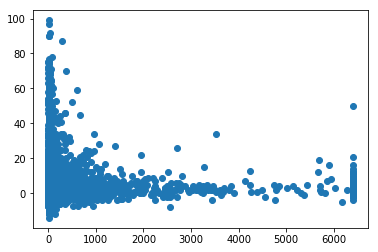

In [160]:
plt.scatter(train['VoronoiAreaRusher'], train['Yards'])

In [163]:
yards = train.pop('Yards')
season = train.pop('Season')
season_weights = season.map({2017: .8, 2018: 1.2}).values

# Model build

In [165]:
fill_val = -999

In [166]:
X = train.copy()

y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1

In [167]:
col_order = sorted(train.columns)
X = X[col_order]
scaler = StandardScaler()
X = scaler.fit_transform(X.fillna(fill_val))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [168]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=SEED)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(19695, 536) (3476, 536)
(19695, 199) (3476, 199)


In [169]:
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        
        print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s

In [170]:
def get_model(x_tr,y_tr,x_val,y_val,w_tr):
    inp = Input(shape = (x_tr.shape[1],))
    x = Dense(1024, input_dim=X.shape[1], activation='relu')(inp)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    out = Dense(199, activation='softmax')(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])

    es = EarlyStopping(
        monitor='CRPS_score_val', 
        mode='min',
        restore_best_weights=True, 
        verbose=1, 
        patience=10
    )

    mc = ModelCheckpoint(
        'best_model.h5',
        monitor='CRPS_score_val',
        mode='min',
        save_best_only=True, 
        verbose=1, 
        save_weights_only=True
    )
    
    bsz = 1024
    steps = x_tr.shape[0] / bsz
    
    model.fit(
        x_tr, 
        y_tr,
        callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc], 
        epochs=100, 
        batch_size=bsz,
        sample_weight=w_tr,
        verbose=1
    )
    model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * x_val.shape[0])
    crps = np.round(val_s, 6)

    return model,crps

In [171]:
losses = []
models = []
crps_csv = []
s_time = time.time()

for k in range(2):
    kfold = KFold(5, random_state=SEED + k, shuffle=True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(yards)):
        print("-----------")
        print("-----------")
        tr_x, tr_y = X[tr_inds],y[tr_inds]
        val_x, val_y = X[val_inds],y[val_inds]
        w_tr = season_weights[tr_inds]
        model,crps = get_model(tr_x,tr_y,val_x,val_y,w_tr)
        models.append(model)
        print("the %d fold crps is %f"%((k_fold+1),crps))
        crps_csv.append(crps)

print("mean crps is %f"%np.mean(crps_csv))

def predict(x_te):
    model_num = len(models)
    for k,m in enumerate(models):
        if k==0:
            y_pred = m.predict(x_te, batch_size=1024)
        else:
            y_pred += m.predict(x_te, batch_size=1024)
            
    y_pred = y_pred / model_num
    
    return y_pred

-----------
-----------
validation shape 2
Epoch 1/100
18536/18536 [==============================] - 2s 102us/step - loss: 5.5989

Epoch 00001: CRPS_score_val improved from inf to 0.08056, saving model to best_model.h5
Epoch 2/100
18536/18536 [==============================] - 1s 71us/step - loss: 5.1257

Epoch 00002: CRPS_score_val improved from 0.08056 to 0.07764, saving model to best_model.h5
Epoch 3/100
18536/18536 [==============================] - 1s 72us/step - loss: 4.6744

Epoch 00003: CRPS_score_val improved from 0.07764 to 0.07326, saving model to best_model.h5
Epoch 4/100
18536/18536 [==============================] - 1s 71us/step - loss: 4.2211

Epoch 00004: CRPS_score_val improved from 0.07326 to 0.05787, saving model to best_model.h5
Epoch 5/100
18536/18536 [==============================] - 1s 71us/step - loss: 3.7926

Epoch 00005: CRPS_score_val improved from 0.05787 to 0.03485, saving model to best_model.h5
Epoch 6/100
18536/18536 [==============================] - 1

18537/18537 [==============================] - 1s 73us/step - loss: 2.7943

Epoch 00011: CRPS_score_val improved from 0.01340 to 0.01332, saving model to best_model.h5
Epoch 12/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.7498

Epoch 00012: CRPS_score_val improved from 0.01332 to 0.01328, saving model to best_model.h5
Epoch 13/100
18537/18537 [==============================] - 1s 74us/step - loss: 2.7346

Epoch 00013: CRPS_score_val improved from 0.01328 to 0.01324, saving model to best_model.h5
Epoch 14/100
18537/18537 [==============================] - 1s 72us/step - loss: 2.7124

Epoch 00014: CRPS_score_val improved from 0.01324 to 0.01321, saving model to best_model.h5
Epoch 15/100
18537/18537 [==============================] - 1s 72us/step - loss: 2.6873

Epoch 00015: CRPS_score_val improved from 0.01321 to 0.01320, saving model to best_model.h5
Epoch 16/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.6621

Epoch 00016: CRPS_s

18537/18537 [==============================] - 1s 73us/step - loss: 2.5442

Epoch 00027: CRPS_score_val did not improve from 0.01276
Epoch 28/100
18537/18537 [==============================] - 1s 72us/step - loss: 2.5421

Epoch 00028: CRPS_score_val did not improve from 0.01276
Epoch 29/100
18537/18537 [==============================] - 1s 71us/step - loss: 2.5285

Epoch 00029: CRPS_score_val did not improve from 0.01276
Epoch 30/100
18537/18537 [==============================] - 1s 72us/step - loss: 2.5173

Epoch 00030: CRPS_score_val did not improve from 0.01276
Epoch 31/100
18537/18537 [==============================] - 1s 72us/step - loss: 2.5141

Epoch 00031: CRPS_score_val did not improve from 0.01276
Epoch 32/100
18537/18537 [==============================] - 1s 72us/step - loss: 2.4955

Epoch 00032: CRPS_score_val did not improve from 0.01276
Epoch 33/100
18537/18537 [==============================] - 1s 72us/step - loss: 2.4878

Epoch 00033: CRPS_score_val did not improve from

the 4 fold crps is 0.012085
-----------
-----------
validation shape 2
Epoch 1/100
18537/18537 [==============================] - 2s 102us/step - loss: 5.6163

Epoch 00001: CRPS_score_val improved from inf to 0.07706, saving model to best_model.h5
Epoch 2/100
18537/18537 [==============================] - 1s 72us/step - loss: 5.1524

Epoch 00002: CRPS_score_val improved from 0.07706 to 0.07551, saving model to best_model.h5
Epoch 3/100
18537/18537 [==============================] - 1s 72us/step - loss: 4.7230

Epoch 00003: CRPS_score_val improved from 0.07551 to 0.07184, saving model to best_model.h5
Epoch 4/100
18537/18537 [==============================] - 1s 73us/step - loss: 4.2570

Epoch 00004: CRPS_score_val improved from 0.07184 to 0.05360, saving model to best_model.h5
Epoch 5/100
18537/18537 [==============================] - 1s 72us/step - loss: 3.8105

Epoch 00005: CRPS_score_val improved from 0.05360 to 0.03304, saving model to best_model.h5
Epoch 6/100
18537/18537 [=======

18536/18536 [==============================] - 1s 73us/step - loss: 2.8879

Epoch 00009: CRPS_score_val improved from 0.01419 to 0.01371, saving model to best_model.h5
Epoch 10/100
18536/18536 [==============================] - 1s 72us/step - loss: 2.8300

Epoch 00010: CRPS_score_val improved from 0.01371 to 0.01350, saving model to best_model.h5
Epoch 11/100
18536/18536 [==============================] - 1s 72us/step - loss: 2.7834

Epoch 00011: CRPS_score_val improved from 0.01350 to 0.01342, saving model to best_model.h5
Epoch 12/100
18536/18536 [==============================] - 1s 73us/step - loss: 2.7555

Epoch 00012: CRPS_score_val improved from 0.01342 to 0.01336, saving model to best_model.h5
Epoch 13/100
18536/18536 [==============================] - 1s 72us/step - loss: 2.7289

Epoch 00013: CRPS_score_val improved from 0.01336 to 0.01328, saving model to best_model.h5
Epoch 14/100
18536/18536 [==============================] - 1s 72us/step - loss: 2.7065

Epoch 00014: CRPS_s

18537/18537 [==============================] - 1s 74us/step - loss: 2.5751

Epoch 00026: CRPS_score_val improved from 0.01238 to 0.01238, saving model to best_model.h5
Epoch 27/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.5580

Epoch 00027: CRPS_score_val did not improve from 0.01238
Epoch 28/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.5455

Epoch 00028: CRPS_score_val did not improve from 0.01238
Epoch 29/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.5305

Epoch 00029: CRPS_score_val did not improve from 0.01238
Epoch 30/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.5185

Epoch 00030: CRPS_score_val did not improve from 0.01238
Epoch 31/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.5170

Epoch 00031: CRPS_score_val did not improve from 0.01238
Epoch 32/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.4963

Epoch 00032: 

18537/18537 [==============================] - 1s 73us/step - loss: 5.1023

Epoch 00002: CRPS_score_val did not improve from 0.07647
Epoch 3/100
18537/18537 [==============================] - 1s 73us/step - loss: 4.6347

Epoch 00003: CRPS_score_val improved from 0.07647 to 0.07137, saving model to best_model.h5
Epoch 4/100
18537/18537 [==============================] - 1s 74us/step - loss: 4.1877

Epoch 00004: CRPS_score_val improved from 0.07137 to 0.05480, saving model to best_model.h5
Epoch 5/100
18537/18537 [==============================] - 1s 73us/step - loss: 3.7834

Epoch 00005: CRPS_score_val improved from 0.05480 to 0.03251, saving model to best_model.h5
Epoch 6/100
18537/18537 [==============================] - 1s 74us/step - loss: 3.4373

Epoch 00006: CRPS_score_val improved from 0.03251 to 0.01878, saving model to best_model.h5
Epoch 7/100
18537/18537 [==============================] - 1s 74us/step - loss: 3.1815

Epoch 00007: CRPS_score_val improved from 0.01878 to 0.0147

18537/18537 [==============================] - 1s 72us/step - loss: 2.6715

Epoch 00017: CRPS_score_val improved from 0.01305 to 0.01303, saving model to best_model.h5
Epoch 18/100
18537/18537 [==============================] - 1s 72us/step - loss: 2.6553

Epoch 00018: CRPS_score_val did not improve from 0.01303
Epoch 19/100
18537/18537 [==============================] - 1s 74us/step - loss: 2.6394

Epoch 00019: CRPS_score_val improved from 0.01303 to 0.01300, saving model to best_model.h5
Epoch 20/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.6273

Epoch 00020: CRPS_score_val improved from 0.01300 to 0.01300, saving model to best_model.h5
Epoch 21/100
18537/18537 [==============================] - 1s 73us/step - loss: 2.6131

Epoch 00021: CRPS_score_val improved from 0.01300 to 0.01297, saving model to best_model.h5
Epoch 22/100
18537/18537 [==============================] - 1s 77us/step - loss: 2.6027

Epoch 00022: CRPS_score_val did not improve from 0.012

In [172]:
print("mean crps is %f"%np.mean(crps_csv))

mean crps is 0.012759


In [173]:
from kaggle.competitions import nflrush

names = dict(zip(range(199), ['Yards%d' % i for i in range(-99, 100)]))

env = nflrush.make_env()
for i, (df_test, sample_pred) in enumerate(env.iter_test()):
    test = processor.initial_cleaning(df_test)
    test = processor.transform(test)    
    
    for col in col_order:
        if col not in test.columns:
            test[col] = 0
            
    test = test[col_order]
    scaled_test = scaler.transform(test.fillna(fill_val))    
    y_pred = predict(scaled_test)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]

    preds_df = pd.DataFrame(data=[y_pred], columns=sample_pred.columns)
    if i == 0:
        all_preds = preds_df
        all_test_rows = test
    else:
        all_preds = pd.concat([all_preds, preds_df], ignore_index=True, sort=False)
        all_test_rows = pd.concat([all_test_rows, test], ignore_index=True, sort=False)
    env.predict(preds_df)
all_test_rows.to_csv('X_test.csv')
env.write_submission_file()

ModuleNotFoundError: No module named 'kaggle'